<a href="https://colab.research.google.com/github/although2013/network/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.2 MB/s eta 0:00:00


In [2]:
!pip install -q datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). This one is the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, a collection of annotated forms.

In [3]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd-layoutlmv3.py:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

As we can see, the dataset consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

Let's check the features:

In [5]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(mode=None, decode=True, id=None)}

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

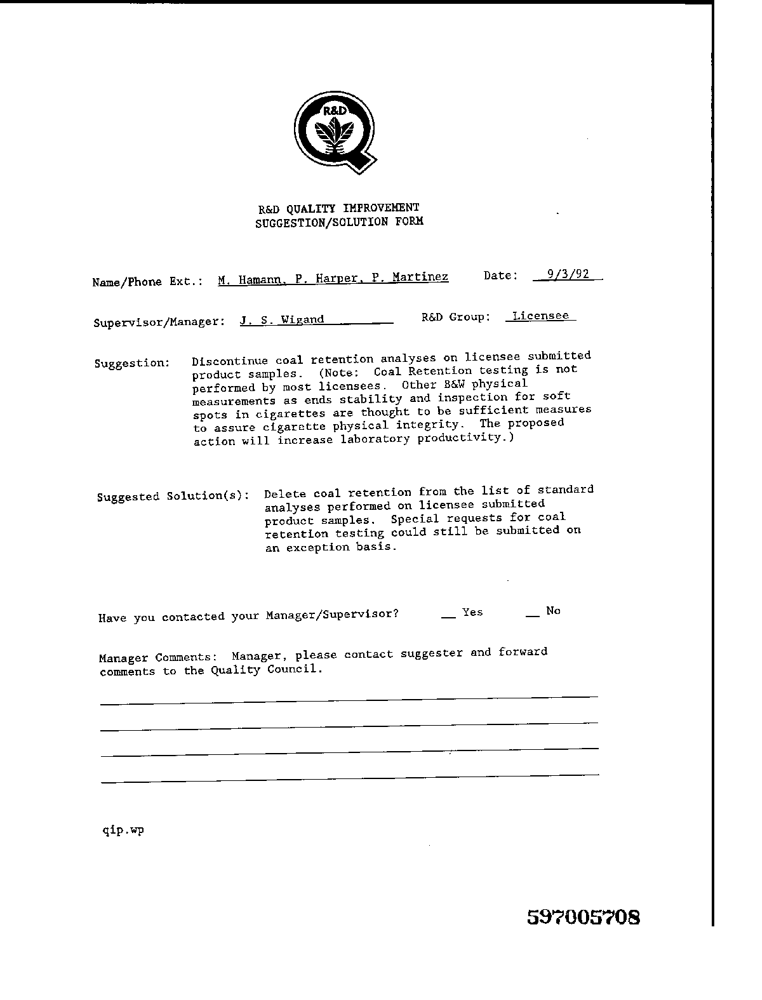

In [6]:
example = dataset["train"][0]
example["image"]

In [7]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'performed', 'on', 'licen

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [8]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

We'll first create `id2label` and label2id mappings, useful for inference. Note that `LayoutLMv3ForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [9]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [10]:
print(label_list)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [11]:
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


Next, we'll define a function which we can apply on the entire dataset.

In [12]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [13]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [14]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [15]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip . wp</s><pad><pad><pad><pad><pad><pad><pad>

Next, we set the format to PyTorch.

In [16]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [17]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [18]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 50
})

In [19]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

"<s> TO: DATE: 3 Fax: NOTE: 82092117 614 -466 -5087 Dec 10 '98 17 :46 P. 01 ATT. GEN. ADMIN. OFFICE Attorney General Betty D. Montgomery CONFIDENTIAL FACSIMILE TRANSMISSION COVER SHEET (614) 466- 5087 FAX NO. George Baroody (336) 335- 7392 FAX NUMBER: PHONE NUMBER: (336) 335- 7363 NUMBER OF PAGES INCLUDING COVER SHEET: June Flynn for Eric Brown/ (614) 466- 8980 SENDER /PHONE NUMBER: SPECIAL INSTRUCTIONS: IF YOU DO NOT RECEIVE ANY OF THE PAGES PROPERLY, PLEASE CONTACT SENDER AS SOON AS POSSIBLE THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. I

In [20]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5
e -100
 Yes 3
 No 3
 5 0
97 -100
005 -100
708 -100
 R 1
& -100
D -100
 QU 2
AL -100
ITY -100
 IM 2
PROV -100
EMENT -100
 S 2
UG -100
G -100
EST -100
ION -100
/ -100
 SOL 2
UTION -100
 FORM 2
 Name 3
 / 4
 Phone 4
 Ext 4
. -100
 : 4
 M 5
. -100
 Ham 6
ann -100
 P 6
. -100
 Harper 6
, -100
 P 6
. -100
 Martinez 6
 9 5
/ -100
 3 6
/ -100
 92 6
 R 3
& -100
D -100
 Group 4
: -100
 J 5
. -100
 S 6
. -100
 W 6
ig -100
and -100
 Supervisor 3
 / 4
 Manager 4
 Disc 5
ont -100
in -100
ue -100
 coal 6
 retention 6
 analyses 6
 on 6
 licensee 6
 submitted 6
 product 6
 samples 6
 ( 6
Note -100
 : 6
 Coal 6
 Ret 6
ention -100
 testing 6
 is 6
 not 6
 performed 6
 by 6
 most 6
 license 6
es -100
. -100
 Other 6
 B 6
& -100
W -100
 physical 6
 measurements 6
 as 6
 ends 6
 stability 6
 and 6
 inspection 6
 for 6
 soft 6
 spots 6
 in 6
 c 6
ip -100
arettes -100
 are 6
 thought 6
 to 6
 be 6
 sufficient 6
 measures 6
 

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [22]:
!pip install evaluate

import evaluate
metric = evaluate.load("accuracy")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [23]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [24]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [25]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [26]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-26-40bb2881a99e>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train the model

Let's train!

In [27]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss


ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)},
Input predictions: [['B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ANSWER', 'O', 'O', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'I-ANSWER', 'O', 'O', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER'], ['B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ANSWER', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-QUESTION', 'B-ANSWER', 'I-QUESTION', 'I-QUESTION', 'I-ANSWER', 'B-ANSWER', 'I-QUESTION', 'I-QUESTION', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-QUESTION', 'I-QUESTION', 'I-ANSWER', 'B-ANSWER', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-ANSWER', 'B-ANSWER', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-ANSWER', 'B-ANSWER', 'I-QUESTION', 'I-QUESTION', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O'], ['B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'O', 'O', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O'], ..., ['B-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'O', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER'], ['O', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'O', 'B-QUESTION', 'B-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-HEADER', 'O', 'O', 'O', 'I-HEADER', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'O', 'O', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'O', 'B-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'O', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'O', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'O', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'I-ANSWER', 'O', 'O', 'O', 'I-ANSWER', 'I-ANSWER', 'O', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION']],
Input references: [['B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER'], ['B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-HEADER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-HEADER', 'I-HEADER', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O'], ['B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'O', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O'], ..., ['B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'O', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER'], ['B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'O', 'O', 'O', 'O', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'O', 'B-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'O', 'O', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'O', 'O', 'B-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

## Evaluate the model

NOTE: we end up with an F1 score of about 90%. Here's what I got on a typical run:
```
Step	Training Loss	Val Loss	Precision	Recall	F1	Accuracy
100	  No log	  0.716025	0.752040	0.824143	0.786442	0.780459
200	  No log	  0.584986	0.828558	0.876304	0.851762	0.801973
300	  No log	  0.525926	0.859583	0.900149	0.879398	0.833947
400	  No log	  0.492821	0.881413	0.904620	0.892866	0.854630
500	  0.561200	0.528126	0.858382	0.885246	0.871607	0.852490
600	  0.561200	0.547107	0.888023	0.906110	0.896976	0.847973
700	  0.561200	0.555438	0.887338	0.915549	0.901222	0.859384
800	  0.561200	0.582942	0.881471	0.905117	0.893137	0.854749
900	  0.561200	0.599762	0.891051	0.910084	0.900467	0.852015
1000	0.133400	0.608207	0.887222	0.910581	0.898750	0.847855
````

However, this score cannot be directly compared to LayoutLM and LayoutLMv2, as LayoutLMv3 employs so-called **segment position embeddings** (inspired by [StructuralLM](https://arxiv.org/abs/2105.11210)). This means that several tokens that belong to the same "segment" (let's say, an address) get the same bounding box coordinates, and in return the same 2D position embeddings.

This is also mentioned in the paper:
>  Note that LayoutLMv3 and StructuralLM use segment-level layout positions, while the other works use word-level layout positions. The use of segment-level positions may benefit the semantic entity labeling task on FUNSD [25], so the two types of work are not directly comparable.

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:813: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


{'epoch': 13.33,
 'eval_accuracy': 0.8478545108760251,
 'eval_f1': 0.8987496935523414,
 'eval_loss': 0.6082074642181396,
 'eval_precision': 0.8872216844143272,
 'eval_recall': 0.910581222056632,
 'eval_runtime': 3.4127,
 'eval_samples_per_second': 14.651,
 'eval_steps_per_second': 7.326}

## Inference

You can load the model for inference as follows:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

loading configuration file /content/test/checkpoint-1000/config.json
Model config LayoutLMv3Config {
  "_name_or_path": "/content/test/checkpoint-1000",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-HEADER",
    "2": "I-HEADER",
    "3": "B-QUESTION",
    "4": "I-QUESTION",
    "5": "B-ANSWER",
    "6": "I-ANSWER"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "label2id": {
    "B-ANSWER": 5,
    "B-HEADER": 1,
    "B-QUESTION": 3,
    "I-ANSWER": 6,
    "I-HEADER": 2,
    "I-QUESTION": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,


Let's take an example of the training dataset to show inference.

In [ ]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


We first prepare it for the model using the processor.

In [ ]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:813: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


The model outputs logits of shape (batch_size, seq_len, num_labels).

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 360, 7])

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [ ]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[0, 3, 4, 3, 3, 4, 5, 3, 3, 4, 3, 4, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 

Let's compare this to the ground truth: note that many labels are -100, as we're only labeling the first subword token of each word.

NOTE: at "true inference" time, you don't have access to labels, see the latest section of this notebook how you can use `offset_mapping` in that case.

In [ ]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 3, -100, 3, -100, -100, 5, 3, -100, -100, 3, -100, 0, -100, -100, 5, -100, 6, -100, 6, -100, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, -100, 2, 1, -100, -100, -100, 2, -100, -100, 2, -100, -100, 2, 2, -100, 5, -100, -100, 6, -100, -100, 6, -100, 3, -100, 4, -100, 5, 6, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, -100, -100, 3, -100, 4, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, 4, -100, 4, -100, 4, 4, -100, -100, 5, 6, 6, 6, 6, -100, 6, -100, -100, 6, -100, -100, 6, -100, 3, -100, -100, 4, -100, -100, 4, -100, -100, 3, 4, -100, -100, -100, 1, 2, 2, 2, 2, -100, -100, 2, 2, 2, 2, -100, 2, -100, -100, -100, 2, 2, -100, 2, -100, -100, 2, 2, -100, 2, 2, -100, -100, 5, 6, -100, -100, -100, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, -100, 6, 6, -100, 6, 6, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, -100, -100, 6, -100, -100, -100, -100, 6, 6, -100, -100, 6, 6, -100, 

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

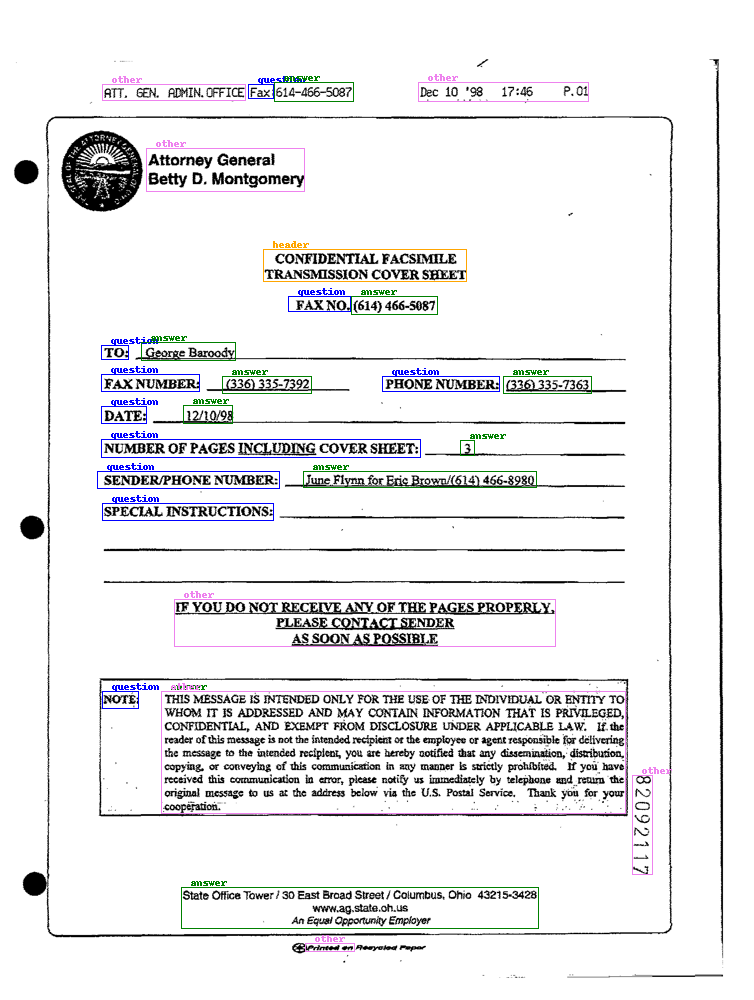

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

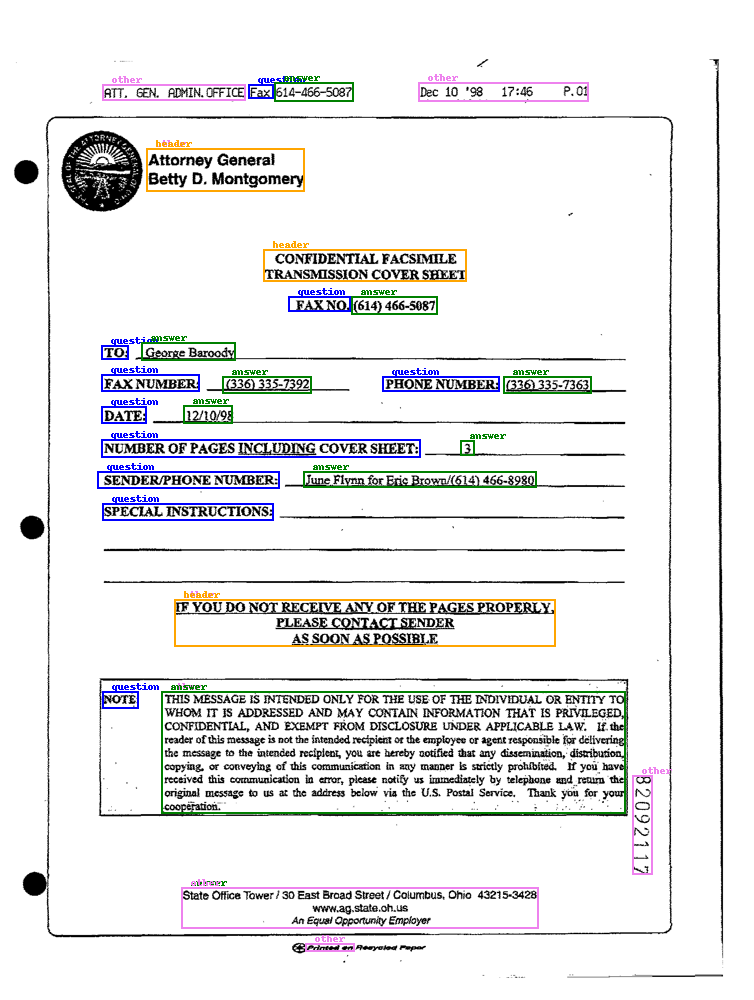

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer. I do have a notebook for that (for LayoutLMv2, but it's equivalent for LayoutLMv3) [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb).